# 파이토치 입문

## 3. 합성곱 신경망

### (1) 합성곱 연산과 풀링 연산

#### 1) 합성곱 연산

In [1]:
import torch
from torch import nn


In [2]:
nn.Conv2d
torch.nn.functional.conv2d


<function torch._VariableFunctionsClass.conv2d>

#### 2) 풀링 연산

In [3]:
nn.AvgPool2d
torch.nn.functional.avg_pool2d
nn.MaxPool2d
torch.nn.functional

<module 'torch.nn.functional' from '/home/aeolian83/anaconda3/envs/torch_for_p397/lib/python3.9/site-packages/torch/nn/functional.py'>

### (2) AlexNet

In [4]:
# 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
# CIFAR10 Dataset 불러오기
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset pipeline
trainset = torchvision.datasets.CIFAR10('./data', train = True, download = True, transform = transform)
trainloader = DataLoader(trainset, batch_size = 32, shuffle = True)

# testset pipeline
testset = torchvision.datasets.CIFAR10('./data', train = False, download = True, transform = transform)
testloader = DataLoader(testset, batch_size = 32, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda is available.


In [15]:
# Build AlexNet

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*3*3, 1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)

        return x

In [19]:
from torchsummary import summary

model = AlexNet()
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Lin

In [21]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         110,784
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          65,792
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
          Dropout-14                 [-

In [22]:
del model

#### 1) adam optimizer로 훈련결과 살피기

In [26]:
# Define loss function, optimizer

criterion = nn.CrossEntropyLoss() # 다중 분류 문제에서는 기본적으로 Cross Entropy Loss를 기본으로 사용한다. softmax계산까지 포함되어 있으므로 마지막 출력값에 별도의 softmax를 적용할 필요가 없다. 
alexnet_adam = AlexNet().to(device) # 추가로 adam과 madgrad train curve를 비교해 볼 예정이다. 
optimizer_adam = optim.Adam(alexnet_adam.parameters(), lr=1e-3)


In [27]:
# Train AlexNet

loss_ = [] # train curve를 그리기위한 loss 저장요 list
n = len(trainloader) # 배치 개수
for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치데이터, gpu 연산을 위해 .to(device)로 데이터를 gpu로 보내준다. 
        optimizer_adam.zero_grad()
        outputs = alexnet_adam(inputs)
        loss = criterion(outputs, labels) # evaluate loss fucntion
        loss.backward()
        optimizer_adam.step()
        running_loss += loss.item()

    loss_.append(running_loss / n) # mean of each epoch 
    print(f'[{epoch+1}] loss: {running_loss / n}')


[1] loss: 1.636972534298058
[2] loss: 1.2302137810834615
[3] loss: 1.0524647075895004
[4] loss: 0.9240209530235786
[5] loss: 0.8458459808974409
[6] loss: 0.7848522069453431
[7] loss: 0.7353844313536099
[8] loss: 0.6938706545096059
[9] loss: 0.6614358556991347
[10] loss: 0.6235282725713532
[11] loss: 0.5930832054511295
[12] loss: 0.575439214267871
[13] loss: 0.5528917813998953
[14] loss: 0.5248611414482101
[15] loss: 0.514602489297541
[16] loss: 0.4885260992786553
[17] loss: 0.46606154609721817
[18] loss: 0.4580274752972222
[19] loss: 0.43641521137443706
[20] loss: 0.42266737475695704
[21] loss: 0.4012693939700732
[22] loss: 0.3897211461596701
[23] loss: 0.378861639446085
[24] loss: 0.3708399349963024
[25] loss: 0.3524554305574639
[26] loss: 0.3492522443849081
[27] loss: 0.3336929438083944
[28] loss: 0.33702667976979234
[29] loss: 0.31115698745987846
[30] loss: 0.3081530695900283
[31] loss: 0.29868239068479224
[32] loss: 0.307070955188417
[33] loss: 0.2841317022585156
[34] loss: 0.28652

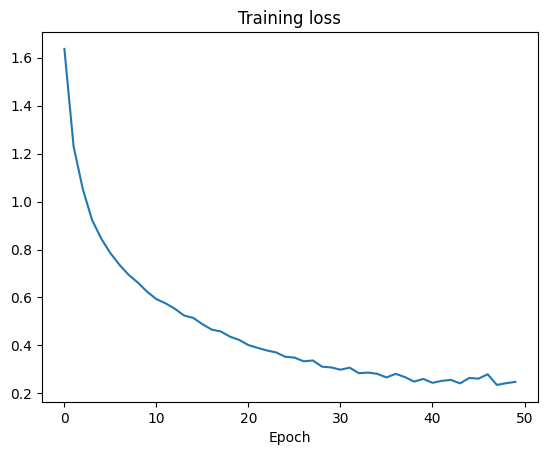

In [29]:
# 학습 손실 함수 그래프 그리기
plt.plot(loss_)
plt.title('Training loss')
plt.xlabel("Epoch")
plt.show()

In [30]:
# 모델 저장

path_adam = './models/cifar10_alexnet_adam.pth'
torch.save(alexnet_adam.state_dict(), path_adam)

In [31]:
# 모델 불러오기

# alexnet_adam = AlexNet().to(device) # 모델 저장은 모델을 통째로 저장하는 것이 아니라고 파라미터를 저장 하는 것이기 때문에 선언적으로 같은 구조의 모델이 선언되어 있어야 한다. 
# alexnet_adam.load_state_dict(torch.load(path_adam))

#### 2) madgrad optimizer로 훈련결과 살펴보기

In [33]:
import madgrad

In [41]:
# Define loss function, optimizer

criterion_mad = nn.CrossEntropyLoss() # 다중 분류 문제에서는 기본적으로 Cross Entropy Loss를 기본으로 사용한다. softmax계산까지 포함되어 있으므로 마지막 출력값에 별도의 softmax를 적용할 필요가 없다. 
alexnet_mad = AlexNet().to(device) # 추가로 adam과 madgrad train curve를 비교해 볼 예정이다. 
optimizer_mad = madgrad.MADGRAD(alexnet_mad.parameters(), lr = 1e-3)

In [42]:
# Train AlexNet

loss_mad = [] # train curve를 그리기위한 loss 저장요 list
n = len(trainloader) # 배치 개수
for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치데이터, gpu 연산을 위해 .to(device)로 데이터를 gpu로 보내준다. 
        optimizer_mad.zero_grad()
        outputs = alexnet_mad(inputs)
        loss = criterion_mad(outputs, labels) # evaluate loss fucntion
        loss.backward()
        optimizer_mad.step()
        running_loss += loss.item()

    loss_mad.append(running_loss / n) # mean of each epoch 
    print(f'[{epoch+1}] loss: {running_loss / n}')


[1] loss: 1.7979409960852322
[2] loss: 1.3997829836374358
[3] loss: 1.2064489800809517
[4] loss: 1.1085761824404667
[5] loss: 1.0538646224135402
[6] loss: 1.021957310322989
[7] loss: 1.0022775827694306
[8] loss: 1.000449334457755
[9] loss: 0.9789705817812311
[10] loss: 0.9745905952467342
[11] loss: 0.9803260336758155
[12] loss: 0.9793550691883761
[13] loss: 0.9844963969287397
[14] loss: 1.0063548980427337
[15] loss: 0.9868239264837535
[16] loss: 0.99878162704289
[17] loss: 0.991762627929125
[18] loss: 1.025475088957404
[19] loss: 0.991666710708512
[20] loss: 1.012294818175884
[21] loss: 1.016772724845359
[22] loss: 1.0105369193425793
[23] loss: 1.0286622623068662
[24] loss: 1.0015869267232436
[25] loss: 1.0207231861425377
[26] loss: 1.0225517787921146
[27] loss: 1.0512888340597646
[28] loss: 1.0549117089728857
[29] loss: 1.0560122878789444
[30] loss: 1.0779005466785785
[31] loss: 1.0476871654915643
[32] loss: 1.072592841724669
[33] loss: 1.026067954412425
[34] loss: 1.0552966332138156


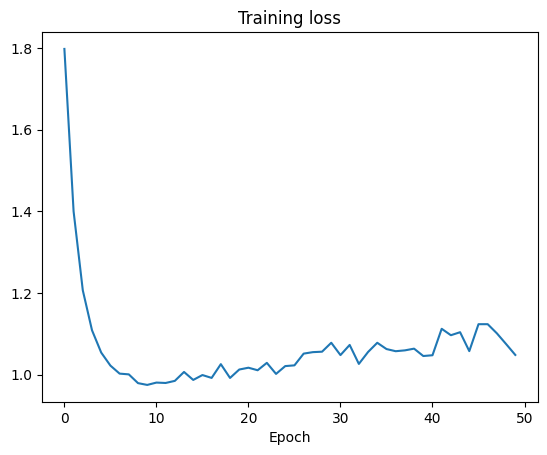

In [43]:
# 학습 손실 함수 그래프 그리기
plt.plot(loss_mad)
plt.title('Training loss')
plt.xlabel("Epoch")
plt.show()

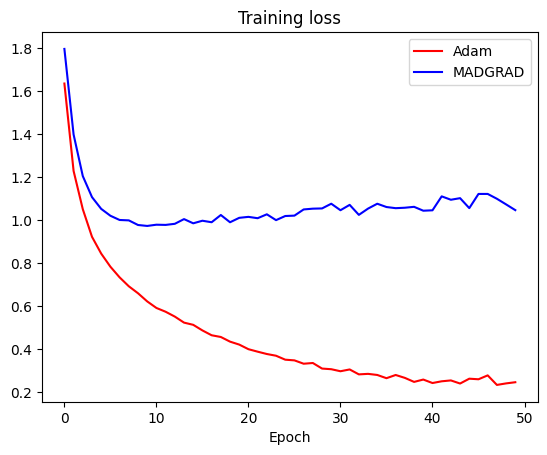

In [44]:
plt.plot(loss_, 'r-')
plt.plot(loss_mad, 'b-')
plt.title('Training loss')
plt.xlabel("Epoch")
plt.legend(['Adam', 'MADGRAD'])
plt.show()